In [218]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming
from nltk.metrics.scores import recall

%matplotlib inline

In [219]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [220]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [221]:
from nmt_run import *

In [222]:
model_files = [f for f in os.listdir(os.path.dirname(model_fil))
                   if os.path.basename(model_fil).replace('.model','') in f]
# print(model_files)

In [223]:
max_model_fil = max(model_files, key=lambda s: int(s.split('_')[-1].split('.')[0]))

In [224]:
max_model_fil

'seq2seq_sen-138819_hwy0-dec3_emb-256-h-256__full1__sp_en_w_gru_drpt-0.3_noise-0_l2-0.001000_32_32_2_2_2DCNN_BN_LN_enc-3_82.model'

In [225]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model found = 
fsh_fbank/seq2seq_sen-138819_hwy0-dec3_emb-256-h-256__full1__sp_en_w_gru_drpt-0.3_noise-0_l2-0.001000_32_32_2_2_2DCNN_BN_LN_enc-3_82.model
loading ...
finished loading ..


In [226]:
log_dev_fil_name

'fsh_fbank/dev_sen-138819_hwy0-dec3_emb-256-h-256__full1__sp_en_w_gru_drpt-0.3_noise-0_l2-0.001000_32_32_2_2_2DCNN_BN_LN_enc-3.log'

In [227]:
log_train = np.loadtxt(log_train_fil_name, delimiter=',', skiprows=False).transpose()
log_test = np.genfromtxt(log_dev_fil_name, delimiter=',', usecols = (0,1,2)).transpose()

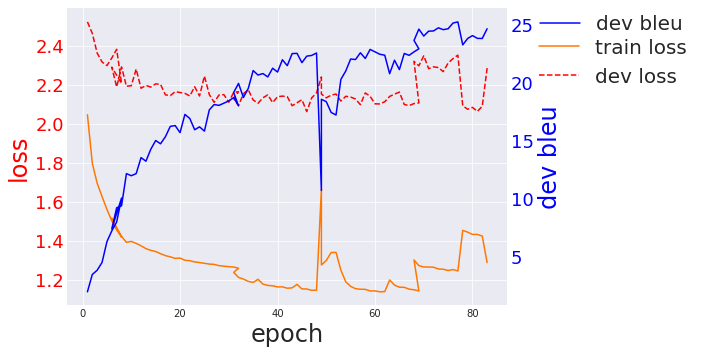

In [228]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax1.set_xlim(0, 60)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
# plt.legend(['dev bleu'], bbox_to_anchor=(1.06, 0.9), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [229]:
import nltk.translate.bleu_score

In [230]:
def play_utt(utt, m_dict):
    sr, y = scipy.io.wavfile.read(os.path.join(wavs_path, utt.rsplit("-",1)[0]+'.wav'))
    start_t = min(seg['start'] for seg in m_dict[utt]['seg'])
    end_t = max(seg['end'] for seg in m_dict[utt]['seg'])
    print(start_t, end_t)
    start_t_samples, end_t_samples = int(start_t*sr), int(end_t*sr)
    display(Audio(y[start_t_samples:end_t_samples], rate=sr))

In [231]:
def display_words(m_dict, v_dict, preds, utts, dec_key, key, play_audio=False, displayN=50):
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        # for reference, 1st word is GO_ID, no need to display
        print("Utterance: {0:s}".format(u))
        display_pp = PrettyTable(["cat","sent"], hrules=True)
        display_pp.align = "l"
        display_pp.header = False
        display_pp.add_row(["es ref", textwrap.fill(es,50)])
        display_pp.add_row(["en ref", textwrap.fill(en,50)])
        display_pp.add_row(["en pred", textwrap.fill(p,50)])

        print(display_pp)
        if play_audio:
            play_utt(u, m_dict)
    

In [232]:
def display_words_latex(m_dict, v_dict, preds, utts, dec_key):
    print("min length={0:d}, max length={1:d}".format(min_len, max_len))
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    total_matching_len = 0

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        # for reference, 1st word is GO_ID, no need to display
        print("Utterance: {0:s}".format(u))
        print("{0:d} & {1:s} & {2:s} & {3:s} \\\\".format(total_matching_len, es, en, p))



In [233]:
def write_predictions_to_file(m_dict, v_dict, preds, utts, dec_key, key, stemmify=False):
    en_hyp = []
    en_ref = []
    ref_key = 'en_w' if 'en_' in dec_key else 'es_w'
    src_key = 'es_w'
    
    for u in tqdm(utts, ncols=80):
        if type(m_dict[u][ref_key]) == list:
            if stemmify:
                en_ref.append(" ".join([stem(w.decode()) for w in m_dict[u]['en_w']]))
            else:
                en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_r_list = []
            for r in m_dict[u][ref_key]:
                if stemmify:
                    en_r_list.append(" ".join([stem(w.decode()) for w in r]))
                else:
                    en_r_list.append(" ".join([w.decode() for w in r]))
            en_ref.append(en_r_list)

    join_str = ' ' if dec_key.endswith('_w') else ''

    total_matching_len = 0

    for u, p in zip(utts, preds):
        if stemmify:
            t_str = join_str.join([stem(v_dict['i2w'][i].decode()) if i != EOS_ID else EOS.decode() for i in p])
        else:
            t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_hyp.append(t_str)

    
    print("writing to file: {0:s}".format("{0:s}_mt-output".format(key)))
    with open("{0:s}_mt-output".format(key), "w") as pred_f:
        for p in en_hyp:
            pred_f.write("{0:s}\n".format(p))
        # end for
    # end while
    
    if type(m_dict[utts[0]][ref_key]) == list:
        with open("{0:s}.ref0".format(key), "w") as ref_f:
            for r in en_ref:
                ref_f.write("{0:s}\n".format(r))
    else:
        num_ref = len(m_dict[u][ref_key])
        for i in range(num_ref):
            with open("{0:s}_en.ref{1:d}".format(key,i), "w") as ref_f:
                for r in en_ref:
                    ref_f.write("{0:s}\n".format(r[i]))
                # end for each utt
            # end with
        # end for reference
    # end else
    print("done")
    return en_ref, en_hyp

### Fisher dev

In [234]:
key='fisher_dev'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 128

In [235]:
cat_speech_path = os.path.join(out_path, key)
wavs_path = os.path.join(out_path, "wavs")

In [236]:
# random.seed("meh")
random.seed("haha")

In [ ]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
fsh_pred_sents, fsh_utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=False, mini=False)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

In [238]:
# Eval parameters
ref_index = -1
min_len, max_len= 0, MAX_EN_LEN
# min_len, max_len = 0, 4
displayN = 50

In [239]:
fsh_filt_pred, fsh_filt_utts = zip(*sorted([(p,u) for p, u in zip(fsh_pred_sents, fsh_utts) if (len(m_dict[u]['es_w']) >= min_len) and 
                                        (len(m_dict[u]['es_w']) <= max_len)]))

In [240]:
print("length filtered utterances = {0:d}".format(len(fsh_filt_utts)))

length filtered utterances = 3977


In [241]:
display_words(m_dict, v_dict, fsh_filt_pred, fsh_filt_utts, 
              dec_key, key, play_audio=False, displayN=displayN)

Utterance: 20051026_180724_341_fsp-A-26
+---------+---+
| es ref  | g |
+---------+---+
| en ref  | g |
+---------+---+
| en pred |   |
+---------+---+
Utterance: 20051009_210519_219_fsp-B-1
+---------+-------+
| es ref  | ¿alo  |
+---------+-------+
| en ref  | hi    |
+---------+-------+
| en pred | hello |
+---------+-------+
Utterance: 20051017_180712_270_fsp-A-3
+---------+-------+
| es ref  | hola  |
+---------+-------+
| en ref  | hello |
+---------+-------+
| en pred | hello |
+---------+-------+
Utterance: 20051017_180712_270_fsp-B-1
+---------+-------+
| es ref  | hello |
+---------+-------+
| en ref  | hello |
+---------+-------+
| en pred | hello |
+---------+-------+
Utterance: 20051017_220530_275_fsp-A-1
+---------+-------+
| es ref  | hola  |
+---------+-------+
| en ref  | hello |
+---------+-------+
| en pred | hello |
+---------+-------+
Utterance: 20051017_220530_275_fsp-A-105
+---------+-------+
| es ref  | ¿aló  |
+---------+-------+
| en ref  | hello |
+---------+

+---------+----------------------------------------------------+
| es ref  | yo fui una vez y sí me gustó porque sí está bonito |
+---------+----------------------------------------------------+
| en ref  | i went once and i did like it it s a nice place    |
+---------+----------------------------------------------------+
| en pred | i was one of if i like it for the the              |
+---------+----------------------------------------------------+
Utterance: 20051025_212334_337_fsp-B-69
+---------+----------------------------------------------------+
| es ref  | sabiendo las otras presas lo que ella hizo y por   |
|         | que ésta                                           |
+---------+----------------------------------------------------+
| en ref  | the other people in jail know what she did and for |
|         | that                                               |
+---------+----------------------------------------------------+
| en pred | i was talking to other three or what s

Utterance: 20051018_210744_280_fsp-B-85
+---------+-----------------------------+
| es ref  | eh tenemos tres dormitorios |
+---------+-----------------------------+
| en ref  | eh we have three bedrooms   |
+---------+-----------------------------+
| en pred | eh we have three thousand   |
+---------+-----------------------------+
Utterance: 20051009_210519_219_fsp-B-28
+---------+--------------------------------------------------+
| es ref  | eh tuvimos eh o sea lo que aprendíamos en la     |
|         | escuela no lo reforzábamos en la casa            |
+---------+--------------------------------------------------+
| en ref  | eh we had eh or that is that which we learned in |
|         | school we didn t reinforce at home               |
+---------+--------------------------------------------------+
| en pred | eh we were eh what we we in school i don t we we |
|         | put in the house                                 |
+---------+------------------------------------------------

Utterance: 20051016_210626_267_fsp-B-45
+---------+----------------------------------------------------+
| es ref  | sí yo lo yo tengo mi jefe mi ex - jefe lo que él   |
|         | hacía cuando le llamaban de un una de esas         |
|         | tarjetas que para rifar en la casa que sé yo       |
+---------+----------------------------------------------------+
| en ref  | yes i i have my boss my former boss the thing he   |
|         | used to do when they called from a one of those    |
|         | cards for a raffle in the house or whatever i don  |
|         | t know                                             |
+---------+----------------------------------------------------+
| en pred | yes i i i i have my daughter my daughter who was   |
|         | when when they call it or a card that pay the home |
|         | that i know i know that i do i know                |
+---------+----------------------------------------------------+
Utterance: 20051026_180724_341_fsp-B-8
+---------+

+---------+---------------------------------------+
Utterance: 20051017_234550_276_fsp-B-107
+---------+---------------------------------------------------+
| es ref  | sí después de las cinco de la tarde puedes llamar |
|         | a quien tu puedes ah o sea marcas el teléfono que |
|         | sale                                              |
+---------+---------------------------------------------------+
| en ref  | yes after five o clock you can call anyone that   |
|         | appears on it you dial the phone number that      |
|         | appears                                           |
+---------+---------------------------------------------------+
| en pred | yes where after five five after they call call    |
|         | call you can call the phone that that             |
+---------+---------------------------------------------------+
Utterance: 20051017_220530_275_fsp-B-31
+---------+---------------------+
| es ref  | sí ella habla bien  |
+---------+--------------------

+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | ah |
+---------+----+
Utterance: 20051016_180547_265_fsp-A-47
+---------+-----+
| es ref  | mhm |
+---------+-----+
| en ref  | mmh |
+---------+-----+
| en pred | ah  |
+---------+-----+
Utterance: 20051016_180547_265_fsp-A-48
+---------+----+
| es ref  | ah |
+---------+----+
| en ref  | ah |
+---------+----+
| en pred | ah |
+---------+----+
Utterance: 20051016_180547_265_fsp-B-17
+---------+-----+
| es ref  | ahh |
+---------+-----+
| en ref  | ahh |
+---------+-----+
| en pred | ah  |
+---------+-----+
Utterance: 20051016_180547_265_fsp-B-19
+---------+-----+
| es ref  | ahh |
+---------+-----+
| en ref  | ahh |
+---------+-----+
| en pred | ah  |
+---------+-----+
Utterance: 20051016_180547_265_fsp-B-32
+---------+-----+
| es ref  | ahh |
+---------+-----+
| en ref  | ah  |
+---------+-----+
| en pred | ah  |
+---------+-----+
Utterance: 20051016_180547_265_fsp-B-34
+---------+----+
|

+---------+---------------------------------------------------+
| es ref  | y y si no sabes no te pagan bien pero tu te pagan |
|         | veinte dólares o un poquito más de veinte dólares |
|         | de lo                                             |
+---------+---------------------------------------------------+
| en ref  | and and if you do not know they do not pay you    |
|         | well but they pay you twenty dollars or a little  |
|         | more than twenty dollars from the                 |
+---------+---------------------------------------------------+
| en pred | and and if you pay it to pay you pay you well but |
|         | you are twenty dollars a little bit more twenty   |
|         | dollars from the                                  |
+---------+---------------------------------------------------+
Utterance: 20051016_180547_265_fsp-A-26
+---------+--------------------------------------------------+
| es ref  | y me contestó y me dijo que que eran varias      |
| 

Utterance: 20051009_182032_217_fsp-A-100
+---------+-------------------------------------------+
| es ref  | entonces en esa andamos por acá estoy     |
+---------+-------------------------------------------+
| en ref  | then that s where we re at over here i am |
+---------+-------------------------------------------+
| en pred | so they we get here here here here        |
+---------+-------------------------------------------+
Utterance: 20051026_211309_346_fsp-A-34
+---------+--------------------------------+
| es ref  | hasta que me olvidé ni ni supe |
+---------+--------------------------------+
| en ref  | until i forgot it i never knew |
+---------+--------------------------------+
| en pred | so they live in                |
+---------+--------------------------------+
Utterance: 20051018_210220_279_fsp-A-52
+---------+----------------------------------------------------+
| es ref  | entonces llegamos aquí y él tampoco te pagan tanto |
|         | eso fue como en el noventa y d

+---------+---------+
| es ref  | ajá ajá |
+---------+---------+
| en ref  | ajá ajá |
+---------+---------+
| en pred | aha aha |
+---------+---------+
Utterance: 20051018_210220_279_fsp-B-21
+---------+-----------+
| es ref  | ajá ajá   |
+---------+-----------+
| en ref  | yeah yeah |
+---------+-----------+
| en pred | aha aha   |
+---------+-----------+
Utterance: 20051018_210220_279_fsp-B-3
+---------+---------+
| es ref  | ajá ajá |
+---------+---------+
| en ref  | aha aha |
+---------+---------+
| en pred | aha aha |
+---------+---------+
Utterance: 20051024_181110_329_fsp-A-72
+---------+---------+
| es ref  | mhm mhm |
+---------+---------+
| en ref  | mmh mmh |
+---------+---------+
| en pred | aha aha |
+---------+---------+
Utterance: 20051024_181110_329_fsp-A-79
+---------+---------+
| es ref  | mhm mhm |
+---------+---------+
| en ref  | mmh mmh |
+---------+---------+
| en pred | aha aha |
+---------+---------+
Utterance: 20051009_182032_217_fsp-B-101
+---------+-----

Utterance: 20051018_210744_280_fsp-B-31
+---------+----------------------------------------------------+
| es ref  | cuando yo le hablo y le pido que me haga algo ella |
|         | lo hace porque si no entonces tu sabes yo me ocupo |
|         | de de que ella lo haga                             |
+---------+----------------------------------------------------+
| en ref  | when i talk to her and i ask her to do something   |
|         | she does it because if not then you know i make    |
|         | sure that she does it                              |
+---------+----------------------------------------------------+
| en pred | when i talk and i i tell him that they give me     |
|         | something and do it because if you know i don t    |
|         | know i don t worry about that they are going       |
+---------+----------------------------------------------------+
Utterance: 20051017_220530_275_fsp-A-89
+---------+---------------------------------------------------+
| es ref  |

Utterance: 20051016_210626_267_fsp-B-57
+---------+--------------------------------------------------+
| es ref  | porque es la misma cosa especialmente cuando me  |
|         | llaman a mi teléfono móvil digo ah               |
+---------+--------------------------------------------------+
| en ref  | because is the same thing especially when they   |
|         | call my cell phone i say ah                      |
+---------+--------------------------------------------------+
| en pred | because there s no thing i do i do that i m when |
|         | when they call me and now you re a mobile        |
+---------+--------------------------------------------------+
Utterance: 20051017_180712_270_fsp-A-38
+---------+----------------------------------------------------+
| es ref  | porque también cuando estamos en el carro ella     |
|         | quiere sus canciones y s- lo que sea y para uno    |
|         | llevar tu sabes llevar quinientos y pico de cds    |
|         | tenerlos en el car

In [242]:
os.chdir("..")
os.chdir("/afs/inf.ed.ac.uk/group/project/lowres/work/chainer2/speech2text")

In [243]:
b, chrf, h, r = calc_bleu(m_dict, 
                          v_dict, 
                          fsh_filt_pred, 
                          fsh_filt_utts, 
                          dec_key, 
                          ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

model_refs = {u: mr for u, mr in zip(fsh_filt_utts, r)}
model_hyps = {u: mh for u, mh in zip(fsh_filt_utts, h)}

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

100%|████████████████████████████████████| 3977/3977 [00:00<00:00, 42019.85it/s]


BLEU score on: fisher_dev = 23.28
------------------------------------------------------------


In [244]:
key

'fisher_dev'

In [245]:
en_ref, en_hyp = write_predictions_to_file(m_dict, v_dict, fsh_filt_pred, fsh_filt_utts, 
                                           dec_key, key, stemmify=False)

100%|████████████████████████████████████| 3977/3977 [00:00<00:00, 40181.31it/s]


writing to file: fisher_dev_mt-output
done


In [246]:
len(en_hyp)

3977

In [247]:
_, _ = corpus_precision_recall(r, h)

total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    59.13 |    31.53|    16.98 |     9.27
recall     |    34.67 |    13.80|     6.37 |     3.17


### Callhome dev

In [248]:
def compute_callhome_metrics():
    key='callhome_devtest'
    train=False
    m_dict = map_dict[key]
    v_dict = vocab_dict[dec_key]
    n=len(map_dict[key])
    BATCH_SIZE = 256

    cat_speech_path = os.path.join(out_path, key)

    print("-"*80)
    print("EPOCH = {0:d}".format(last_epoch+1))
    call_pred_sents, call_utts, loss = feed_model(map_dict[key],
                      b_dict=bucket_dict[key],
                      vocab_dict=vocab_dict,
                      batch_size=BATCH_SIZE,
                      x_key=enc_key,
                      y_key=dec_key,
                      train=train,
                      cat_speech_path=cat_speech_path, use_y=True)

    print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                        "train" if train else "dev",
                                        loss))
    print("-")
    print("-"*80)

    display_words(m_dict, v_dict, call_pred_sents[:displayN], call_utts[:displayN],
                  dec_key, key, min_len=min_len, max_len=max_len, play_audio=False)

    b, _, h, r = calc_bleu(m_dict, 
                                  v_dict, 
                                  call_pred_sents, 
                                  call_utts, 
                                  dec_key, 
                                  min_len=min_len, 
                                  max_len=max_len, 
                                  ref_index=ref_index)

    print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
    print("-"*60)

    all_weights=[(1.,0.,0.,0.),
                 (0.,1.,0.,0.),
                 (0.,0.,1.,0.),
                 (0.,0.,0.,1.),
                 (1./2,1./2,0.,0.),
                 (1./3,1./3,1./3,0.),
                 (.25,.25,.25,.25)]

    print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
    for weights in all_weights:
        b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
        print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

    _, _ = corpus_precision_recall(r, h)

    call_en_ref, call_en_hyp = write_predictions_to_file(m_dict, v_dict, call_pred_sents, call_utts, 
                                                         dec_key, key, min_len=min_len, max_len=max_len, stemmify=False)

    print(len(call_en_ref),len(call_en_hyp))

### Google metrics

In [249]:
google_s2t_path_hyps = "./google-s2t/e2e_ast_decode/hyps/fisher_dev/"
google_s2t_path_refs = "./google-s2t/e2e_ast_decode/refs/fisher_dev/"
google_hyp_fname = 'fisher_spa_eng_ast_003_base_r0.txt'

### Prep Google data

In [250]:
kaldi_segment_map_path = os.path.join(out_path,'kaldi_segment_map.dict')
rev_map_dict_path = os.path.join(out_path,'rev_map.dict')
kaldi_segment_map = pickle.load(open(kaldi_segment_map_path, "rb"))
rev_map_dict = pickle.load(open(rev_map_dict_path, "rb"))


google_s2t_path_mapping = "./google-s2t/e2e_ast_decode/mapping/fisher_dev/"
google_s2t_ref0 = os.path.join(google_s2t_path_mapping, "sorted-normalized-fisher_dev.en.0.mapping")

google_s2t_map_path = os.path.join(out_path, "google_s2t_map.dict")
google_s2t_rev_map_path = os.path.join(out_path, "google_s2t_rev_map.dict")
google_s2t_refs_path = os.path.join(out_path, "google_s2t_refs.dict")
google_s2t_hyps_path = os.path.join(out_path, "google_s2t_hyps.dict")

In [251]:
def prep_google_data():

    google_s2t_map = {}
    google_s2t_rev_map = {}

    r_m_dict = rev_map_dict['fisher_dev']
    with open(google_s2t_ref0, "r") as in_f:
        for i, line in enumerate(in_f, start=1):
            wav_f = line.split(".wav")[0].replace("fisher_dev/", "")
            key_1 = wav_f[:wav_f.find("_fsp")+len("_fsp")]
            key_2 = wav_f.rsplit("_fsp",1)[1].split("_")[0]
            google_s2t_map[i] = r_m_dict[key_1+key_2]
            google_s2t_rev_map[r_m_dict[key_1+key_2]] = i
        # end for
    # end with
    pickle.dump(google_s2t_map, open(google_s2t_map_path, "wb"))
    pickle.dump(google_s2t_rev_map, open(google_s2t_rev_map_path, "wb"))
    
    google_s2t_refs = {}
    for fname in os.listdir(google_s2t_path_refs):
        with open(os.path.join(google_s2t_path_refs,fname), "r") as in_f:
            f_key = fname.rsplit("-",1)[-1].replace(".en.","_ref_")
            google_s2t_refs[f_key] = {}
            for i, line in enumerate(in_f, start=1):
                utt_key = google_s2t_map[i]
                google_s2t_refs[f_key][utt_key] = line.rstrip('\n').split()
            # end for
        # end with
    # end for
    pickle.dump(google_s2t_refs, open(google_s2t_refs_path, "wb"))
    
    google_s2t_hyps = {}
    for fname in os.listdir(google_s2t_path_hyps):
        with open(os.path.join(google_s2t_path_hyps,fname), "r") as in_f:
            f_key = "fisher_dev_{0:s}".format(fname.rsplit("_")[-1].replace(".txt", ""))
            google_s2t_hyps[f_key] = {}
            for i, line in enumerate(in_f, start=1):
                utt_key = google_s2t_map[i]
                google_s2t_hyps[f_key][utt_key] = line.rstrip('\n').split()
            # end for
        # end with
    # end for
    pickle.dump(google_s2t_hyps, open(google_s2t_hyps_path, "wb"))
    return google_s2t_refs, google_s2t_hyps

In [252]:
"." in fsh_utts

False

In [253]:
def write_google_s2t_refs_to_file(google_dict, utts):
    data_lines = {}
    for r in google_dict.keys():
        curr_file_lines = []
        out_fname = "google_"+r+".en"
        with open(out_fname, "w") as out_f:
            print("writing to file: {0:s}".format(out_fname))
            for utt_id in utts:
                words = " ".join(google_dict[r][utt_id])
                out_line = "{0:s}\n".format(words)
                out_f.write(out_line)
                if utt_id not in data_lines:
                    if len(google_dict) > 1:
                        data_lines[utt_id] = [google_dict[r][utt_id]]
                    else:
                        data_lines[utt_id] = google_dict[r][utt_id][:]
                else:
                    data_lines[utt_id].append(google_dict[r][utt_id])
            # end for over utterances
        # end for file        
    # end with
    return data_lines

In [254]:
google_s2t_refs, google_s2t_hyps = prep_google_data()

In [255]:
hyp_key = 'fisher_dev_r0'
google_refs = write_google_s2t_refs_to_file(google_s2t_refs, fsh_filt_utts)
google_hyps = write_google_s2t_refs_to_file({hyp_key : google_s2t_hyps[hyp_key]}, fsh_filt_utts)

writing to file: google_fisher_dev_ref_3.en
writing to file: google_fisher_dev_ref_2.en
writing to file: google_fisher_dev_ref_1.en
writing to file: google_fisher_dev_ref_0.en
writing to file: google_fisher_dev_r0.en


In [256]:
" ".join(map(lambda t: t.decode(), m_dict[rev_map_dict['fisher_dev']['20051009_182032_217_fsp.108']]['en_w'][0]))

'and my dad always taught us that that for you to be to believe in god you don t have to be involved with a church'

In [257]:
print(" ".join([w for w in google_s2t_refs['fisher_dev_ref_0'][fsh_utts[0]]]))
print(" ".join([w for w in google_s2t_hyps['fisher_dev_r0'][fsh_utts[0]]]))
print(" ".join([w for w in h[0]]))

oh
oh



In [258]:
print(len(fsh_utts), len(google_s2t_refs['fisher_dev_ref_0']))

for key in google_s2t_refs['fisher_dev_ref_0']:
    if key not in fsh_utts:
        print(key)
        print(" ".join([w.decode() for w in m_dict[key]['en_w'][0]]))
        print(google_s2t_hyps['fisher_dev_r0']['20051017_220530_275_fsp-B-26'])

3977 3979
20051017_220530_275_fsp-B-21
nothing above in spanish--
['yeah']
20051017_220530_275_fsp-B-26
no words in spanish here lol
['yeah']


In [259]:
google_s2t_refs.keys(), google_s2t_hyps.keys()

(dict_keys(['fisher_dev_ref_3', 'fisher_dev_ref_2', 'fisher_dev_ref_1', 'fisher_dev_ref_0']),
 dict_keys(['fisher_dev_r2', 'fisher_dev_r1', 'fisher_dev_r0']))

In [260]:
google_prec_recall = {'precision' : {}, 'recall' : {}, "tp": 0, "tc": 0, "tr": 0}
model_prec_recall = {'precision' : {}, 'recall' : {}, "tp": 0, "tc": 0, "tr": 0}


for utt_id, ref, hyp in zip(fsh_filt_utts, r, h):
    es_ref = [w.decode() for w in m_dict[utt_id]['es_w']]
    
    pval, rval = modified_precision_recall([google_s2t_refs[i][utt_id] for i in google_s2t_refs], 
                                           google_s2t_hyps['fisher_dev_r0'][utt_id], n=1)

    google_prec_recall['precision'][utt_id] = float(pval)
    google_prec_recall['recall'][utt_id] = float(rval)

    google_prec_recall['tc'] += pval.numerator
    google_prec_recall['tp'] += pval.denominator
    google_prec_recall['tr'] += rval.denominator

    if rval > 1:
        print("ouch", utt_id)
        break

    pval, rval = modified_precision_recall(ref, hyp, n=1)
    model_prec_recall['tc'] += pval.numerator
    model_prec_recall['tp'] += pval.denominator
    model_prec_recall['tr'] += rval.denominator

    model_prec_recall['precision'][utt_id] = float(pval)
    model_prec_recall['recall'][utt_id] = float(rval)
# end for
    
google_prec_recall['total_precision'] = google_prec_recall['tc'] / google_prec_recall['tp']
google_prec_recall['total_recall'] = google_prec_recall['tc'] / google_prec_recall['tr']
model_prec_recall['total_precision'] = model_prec_recall['tc'] / model_prec_recall['tp']
model_prec_recall['total_recall'] = model_prec_recall['tc'] / model_prec_recall['tr']

In [261]:
print("\t\tGoogle metrics")
print("-"*60)
print("{0:10s} = {1:0.3f}\n{2:10s} = {3:0.3f}".format("precision",
                                                      google_prec_recall['total_precision'],
                                                      "recall",
                                                      google_prec_recall['total_recall']))

		Google metrics
------------------------------------------------------------
precision  = 0.766
recall     = 0.425


In [262]:
print("\t\tModel metrics")
print("-"*60)
print("{0:10s} = {1:0.3f}\n{2:10s} = {3:0.3f}".format("precision",
                                                      model_prec_recall['total_precision'],
                                                      "recall",
                                                      model_prec_recall['total_recall']))


		Model metrics
------------------------------------------------------------
precision  = 0.591
recall     = 0.347


In [263]:
print("google-s2t BLEU score:")
"{0:0.3f}".format(corpus_bleu(google_refs.values(), google_hyps.values()))

google-s2t BLEU score:


'0.452'

In [264]:
print("model-s2t BLEU score:")
"{0:0.3f}".format(corpus_bleu(model_refs.values(), model_hyps.values()))

model-s2t BLEU score:


'0.233'

In [265]:
try:
    for i in range(len(list(google_refs.values())[0])):
        print("chrf score using ref:{0:d} = {1:5.3f}".format(i+1, corpus_chrf([ref[i] 
                                                                               for ref in google_refs.values()], 
                                                                              google_hyps.values())))
except:
    print("bleh")

chrf score using ref:1 = 0.787
chrf score using ref:2 = 0.891
chrf score using ref:3 = 0.582
chrf score using ref:4 = 0.787


In [266]:
try:
    for i in range(len(list(model_refs.values())[0])):
        print("chrf score using ref:{0:d} = {1:5.3f}".format(i+1, corpus_chrf([x[i] for x in model_refs.values()], 
                                                                              model_hyps.values())))
except:
    print("bleh")

chrf score using ref:1 = 0.744
chrf score using ref:2 = 0.570
chrf score using ref:3 = 0.823
chrf score using ref:4 = 0.744


In [267]:
print("-"*60)
print("\t\tGOOGLE")
print("-"*60)
_, _ = corpus_precision_recall(google_refs.values(), google_hyps.values())

------------------------------------------------------------
		GOOGLE
------------------------------------------------------------
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    76.60 |    53.99|    38.00 |    26.57
recall     |    42.54 |    22.25|    13.38 |     8.51


In [268]:
print("-"*60)
print("\t\tMODEL")
print("-"*60)
_, _ = corpus_precision_recall(model_refs.values(), model_hyps.values())

------------------------------------------------------------
		MODEL
------------------------------------------------------------
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    59.13 |    31.53|    16.98 |     9.27
recall     |    34.67 |    13.80|     6.37 |     3.17


In [269]:
print("-"*60)
print("\t\tGOOGLE")
print("-"*60)
for ix in range(len(list(google_refs.values())[0])):
    temp_refs = [[i[ix]] for i in google_refs.values()]
    print("-"*60)
    print("\t\tUsing reference = {0:d}".format(ix+1))
    print("-"*60)
    _, _ = corpus_precision_recall(temp_refs, google_hyps.values())

------------------------------------------------------------
		GOOGLE
------------------------------------------------------------
------------------------------------------------------------
		Using reference = 1
------------------------------------------------------------
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    58.26 |    33.86|    20.85 |    13.02
recall     |    57.36 |    33.29|    20.48 |    12.77
------------------------------------------------------------
		Using reference = 2
------------------------------------------------------------
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    57.86 |    33.62|    20.62 |    12.75
recall     |    57.79 |    33.56|    20.57 |    12.71
------------------------------------------------------------
		Using reference = 3
--------------------------------

In [270]:
print("-"*60)
print("\t\tMODEL")
print("-"*60)
for ix in range(len(list(model_refs.values())[0])):
    temp_refs = [[i[ix]] for i in model_refs.values()]
    print("-"*60)
    print("\t\tUsing reference = {0:d}".format(ix+1))
    print("-"*60)
    _, _ = corpus_precision_recall(temp_refs, model_hyps.values())

------------------------------------------------------------
		MODEL
------------------------------------------------------------
------------------------------------------------------------
		Using reference = 1
------------------------------------------------------------
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    44.12 |    19.27|     9.05 |     4.41
recall     |    45.84 |    20.12|     9.50 |     4.65
------------------------------------------------------------
		Using reference = 2
------------------------------------------------------------
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    44.21 |    19.62|     9.44 |     4.77
recall     |    45.92 |    20.48|     9.91 |     5.03
------------------------------------------------------------
		Using reference = 3
---------------------------------

In [271]:
better_utts = {'precision' : [], 'recall' : []}
for utt_id in fsh_filt_utts:
    if len(m_dict[utt_id]['es_w']) >= min_len and len(m_dict[utt_id]['es_w']) <= max_len:
        if model_prec_recall['precision'][utt_id] > google_prec_recall['precision'][utt_id]:
            better_utts['precision'].append(utt_id)
        if model_prec_recall['recall'][utt_id] > google_prec_recall['recall'][utt_id]:
            better_utts['recall'].append(utt_id)

In [272]:
len(better_utts['precision']), len(better_utts['recall']), len(model_prec_recall['recall'])

(488, 572, 3977)

In [273]:
model_predictions = {}
for u, hyp in zip(fsh_filt_utts, h):
    model_predictions[u] = hyp
# print(model_predictions['20051017_220530_275_fsp-A-6'])

In [274]:
with open("better_precision.txt", "w") as out_f:
    for utt_id in better_utts['precision']:
        ref_line = " ".join([w.decode() for w in m_dict[utt_id]['en_w'][0]])
        model_pred = " ".join(model_predictions[utt_id])
        google_pred = " ".join(google_s2t_hyps['fisher_dev_r0'][utt_id])
        out_line = "{0:s}---{1:s}---{2:s}---{3:.3f}---{4:s}---{5:.3f}\n".format(utt_id, 
                                                                                ref_line,
                                                                                model_pred,
                                                                                model_prec_recall['precision'][utt_id], 
                                                                                google_pred,
                                                                                google_prec_recall['precision'][utt_id])
        out_f.write(out_line)
    # end for
# end with
with open("better_recall.txt", "w") as out_f:
    out_line = "{0:s}---{1:s}---{2:s}---{3:s}\n".format('utt_id', 'ref_line', 'model_pred', 'google_pred')
    out_f.write(out_line)
    for utt_id in better_utts['recall']:
        ref_line = " ".join([w.decode() for w in m_dict[utt_id]['en_w'][0]])
        model_pred = " ".join(model_predictions[utt_id])
        google_pred = " ".join(google_s2t_hyps['fisher_dev_r0'][utt_id])
        out_line = "{0:s}---{1:s}---{2:s}---{3:.3f}---{4:s}---{5:.3f}\n".format(utt_id, 
                                                                                ref_line,
                                                                                model_pred,
                                                                                model_prec_recall['recall'][utt_id], 
                                                                                google_pred,
                                                                                google_prec_recall['recall'][utt_id])
        out_f.write(out_line)
    # end for
# end with
        

In [275]:
max(google_prec_recall['recall'].values()), max(model_prec_recall['recall'].values())

(1.0, 1.0)

In [276]:
def rand_jitter(arr, jitter=0.1):
    stdev= jitter * np.std(arr)
    return arr + np.random.randn(len(arr)) * stdev

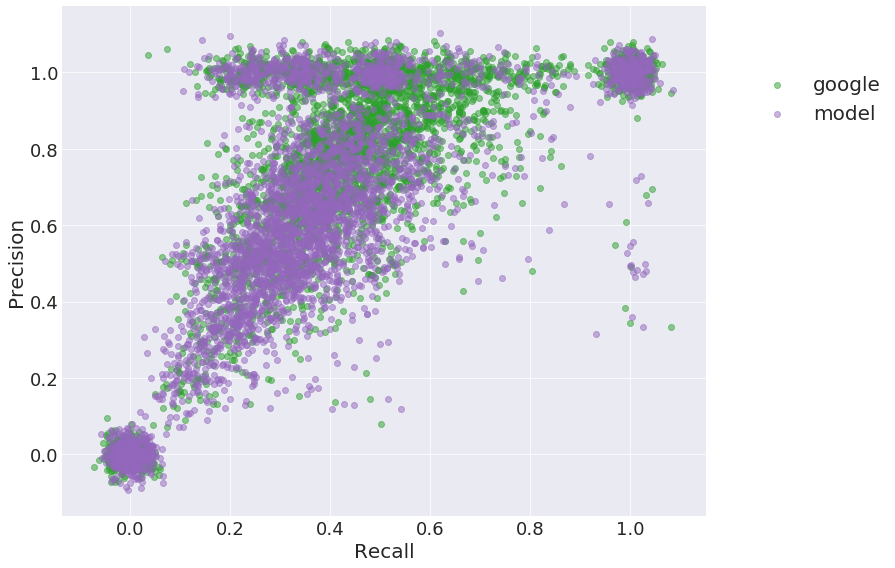

In [277]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_style("darkgrid")

x_vals = np.array(list(google_prec_recall['recall'].values()))
y_vals = np.array(list(google_prec_recall['precision'].values()))

plt.scatter(rand_jitter(x_vals), rand_jitter(y_vals), c=[tableau20[4]], label='google', alpha=0.5)

x_vals = np.array(list(model_prec_recall['recall'].values()))
y_vals = np.array(list(model_prec_recall['precision'].values()))

plt.scatter(rand_jitter(x_vals), rand_jitter(y_vals), c=[tableau20[8]], label='model', alpha=0.5)

plt.xlabel("Recall", size=20)
plt.ylabel("Precision", size=20)

plt.yticks(rotation=0, size=18)
plt.xticks(rotation=0, size=18)        


ax.legend(loc='upper right', bbox_to_anchor=(1.3, 0.9),
                      ncol=1, fancybox=True, shadow=True, fontsize=20)

sns.despine(left=True, bottom=True)

fig.tight_layout()




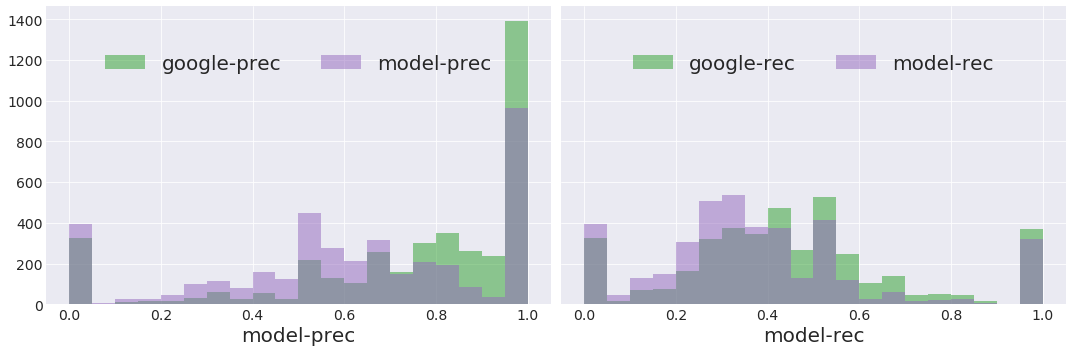

In [278]:
fig, ax = plt.subplots(figsize=(15,5),nrows=1, ncols=2, sharey=True)
sns.set_style("darkgrid")

hist_vals = [
    (np.array(list(google_prec_recall['precision'].values())), 'google-prec', tableau20[4]),
    (np.array(list(google_prec_recall['recall'].values())), 'google-rec', tableau20[4]),
    (np.array(list(model_prec_recall['precision'].values())), 'model-prec', tableau20[8]),
    (np.array(list(model_prec_recall['recall'].values())), 'model-rec', tableau20[8]),
]

for i, (vals, lbl, c) in enumerate(hist_vals):
    curr_ax = ax[i%2]
    curr_ax.hist(vals, label=lbl, color=c, alpha=0.5, bins=20)

    curr_ax.set_xlabel(lbl, size=20)
    for i in curr_ax.get_xticklabels()+curr_ax.get_yticklabels():
        i.set_fontsize(14) 
#     curr_ax.set_yticks(size=18)
#     curr_ax.set_xticks(size=18)        


ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 0.9),
                      ncol=4, fancybox=True, shadow=True, fontsize=20)

ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 0.9),
                      ncol=4, fancybox=True, shadow=True, fontsize=20)


sns.despine(left=True, bottom=True)

fig.tight_layout()

In [279]:
# test_ref = [["ha ha lol hue".split()], ["ha ha ja ha".split()], ["ha ha ja ha".split()]]
# test_h = ["lol ja".split(), "ha he".split(), "ha ja".split()]
# _, _ = corpus_precision_recall(test_ref, test_h)